In [2]:
import os
import joblib  # For saving and loading models
import cv2 as cv
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from skimage.measure import shannon_entropy
from sklearn.preprocessing import StandardScaler
from skimage.feature import local_binary_pattern
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
def preprocess_image(image):
    resized_image = cv.resize(image, (150, 150))
    gray_image = cv.cvtColor(resized_image, cv.COLOR_BGR2GRAY)
    equalized_image = cv.equalizeHist(gray_image)
    blurred_image = cv.GaussianBlur(equalized_image, (5, 5), 0)
    return blurred_image

In [4]:
def extract_histogram(image):
    hist = cv.calcHist([image], [0], None, [256], [0, 256])
    hist = cv.normalize(hist, hist).flatten()
    return hist

def extract_sobel_edges(image):
    sobelx = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=5)
    sobely = cv.Sobel(image, cv.CV_64F, 0, 1, ksize=5)
    sobel_combined = np.hypot(sobelx, sobely)
    sobel_combined = cv.normalize(sobel_combined, sobel_combined).flatten()
    return sobel_combined

def extract_lbp(image):
    lbp = local_binary_pattern(image, 24, 8, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 27), range=(0, 26))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_entropy(image):
    entropy = -np.sum(image * np.log2(image + 1e-10))
    return np.array([entropy])

def extract_hog(image):
    hog = cv.HOGDescriptor()
    h = hog.compute(image)
    return h.flatten() # type : ignore

def extract_corners(image):
    corners = cv.cornerHarris(image, 2, 3, 0.04)
    return corners.flatten()

In [5]:
# def extract_features_set1(image, image_type):
#     processed_image = preprocess_image(image)
#     texture_features = extract_lbp(processed_image)
#     combined_features = []
#     if image_type in ['Buildings', 'Glacier', 'Mountains', 'Streets']:
#         edges = extract_sobel_edges(processed_image)
#         combined_features = np.hstack([texture_features, edges])
#     if image_type == 'Buildings':
#         corners = extract_corners(processed_image)
#         combined_features = np.hstack([combined_features, corners])
#     return combined_features

def extract_features_set1(image, image_type):
    processed_image = preprocess_image(image)
    color_image = cv.cvtColor(cv.resize(image, (150, 150)), cv.COLOR_BGR2RGB)
    combined_features = []
    if image_type == 'Buildings':
        edges = extract_sobel_edges(processed_image)
        texture = extract_lbp(processed_image)
        color_hist = extract_histogram(color_image)
        combined_features = np.hstack([edges, texture, color_hist])
    elif image_type == 'Forest':
        texture = extract_lbp(processed_image)
        color_hist = extract_histogram(color_image)
        combined_features = np.hstack([texture, color_hist])
    elif image_type == 'Glacier':
        edges = extract_sobel_edges(processed_image)
        color_hist = extract_histogram(color_image)
        combined_features = np.hstack([edges, color_hist])
    elif image_type == 'Mountains':
        edges = extract_sobel_edges(processed_image)
        texture = extract_lbp(processed_image)
        combined_features = np.hstack([edges, texture])
    elif image_type == 'Sea':
        texture = extract_lbp(processed_image)
        color_hist = extract_histogram(color_image)
        combined_features = np.hstack([texture, color_hist])
    elif image_type == 'Streets':
        edges = extract_sobel_edges(processed_image)
        texture = extract_lbp(processed_image)
        color_hist = extract_histogram(color_image)
        combined_features = np.hstack([edges, texture, color_hist])
    return combined_features


In [6]:
# def extract_features_set2(image, image_type):
#     processed_image = preprocess_image(image)
#     color_image = cv.cvtColor(cv.resize(image, (150, 150)), cv.COLOR_BGR2RGB)
#     texture_features = extract_lbp(processed_image)
#     color_hist = extract_histogram(color_image)
#     combined_features = []
#     if image_type in ['Buildings', 'Forest', 'Sea', 'Streets']:
#         combined_features = np.hstack([texture_features, color_hist])
#     else:
#         combined_features = np.hstack([texture_features, color_hist, edges])
#     return combined_features


def extract_features_set2(image, image_type):
    processed_image = preprocess_image(image)
    combined_features = []
    if image_type == 'Buildings':
        edges = extract_sobel_edges(processed_image)
        corners = extract_corners(processed_image)
        combined_features = np.hstack([edges, corners])
    elif image_type == 'Forest':
        edges = extract_sobel_edges(processed_image)
        entropy = extract_entropy(processed_image)
        combined_features = np.hstack([edges, entropy])
    elif image_type == 'Glacier':
        edges = extract_sobel_edges(processed_image)
        entropy = extract_entropy(processed_image)
        combined_features = np.hstack([edges, entropy])
    elif image_type == 'Mountains':
        edges = extract_sobel_edges(processed_image)
        entropy = extract_entropy(processed_image)
        combined_features = np.hstack([edges, entropy])
    elif image_type == 'Sea':
        edges = extract_sobel_edges(processed_image)
        entropy = extract_entropy(processed_image)
        combined_features = np.hstack([edges, entropy])
    elif image_type == 'Streets':
        edges = extract_sobel_edges(processed_image)
        corners = extract_corners(processed_image)
        combined_features = np.hstack([edges, corners])
    return combined_features

In [7]:
# def extract_features_set3(image, image_type):
#     preprocessed_image = preprocess_image(image)
#     texture_features = extract_lbp(preprocessed_image)
#     if image_type in ['Forest', 'Sea']:
#         entropy = extract_entropy(preprocessed_image)
#         combined_features = np.hstack([texture_features, entropy])
#     elif image_type == 'Mountains':
#         gradients = extract_hog(preprocessed_image)
#         combined_features = np.hstack([texture_features, gradients])
#     else:
#         combined_features = texture_features      
#     return combined_features



def extract_features_set3(image, image_type):
    processed_image = preprocess_image(image)
    color_image = cv.cvtColor(cv.resize(image, (150, 150)), cv.COLOR_BGR2RGB)
    combined_features = []
    if image_type == 'Buildings':
        texture = extract_lbp(processed_image)
        color_hist = extract_histogram(color_image)
        combined_features = np.hstack([texture, color_hist])
    elif image_type == 'Forest':
        texture = extract_lbp(processed_image)
        color_hist = extract_histogram(color_image)
        combined_features = np.hstack([texture, color_hist])
    elif image_type == 'Glacier':
        texture = extract_lbp(processed_image)
        color_hist = extract_histogram(color_image)
        combined_features = np.hstack([texture, color_hist])
    elif image_type == 'Mountains':
        texture = extract_lbp(processed_image)
        gradients = extract_hog(processed_image)
        combined_features = np.hstack([texture, gradients])
    elif image_type == 'Sea':
        texture = extract_lbp(processed_image)
        gradients = extract_hog(processed_image)
        combined_features = np.hstack([texture, gradients])
    elif image_type == 'Streets':
        texture = extract_lbp(processed_image)
        gradients = extract_hog(processed_image)
        color_hist = extract_histogram(color_image)
        combined_features = np.hstack([texture, gradients, color_hist])
    return combined_features

In [10]:
# def load_and_preprocess_images(folder, feature_set_extractor):
#     features = []
#     labels = []
#     max_length = 0  # Initialize maximum length to zero
#     for category in os.listdir(folder):
#         category_path = os.path.join(folder, category)
#         if os.path.isdir(category_path):
#             for filename in os.listdir(category_path):
#                 img_path = os.path.join(category_path, filename)
#                 image = cv.imread(img_path)
#                 if image is not None:
#                     feature_vector = feature_set_extractor(image, category)
#                     features.append(feature_vector)
#                     labels.append(category)
#                     max_length = max(max_length, len(feature_vector))  # Update maximum length
#                     print('max_length', max_length)
    
#     # Pad feature vectors to the length of the longest vector
#     for i in range(len(features)):
#         features[i] = np.pad(features[i], (0, max_length - len(features[i])), mode='constant')

#     return np.array(features), np.array(labels)

In [12]:
from sklearn.preprocessing import LabelEncoder

import joblib

def load_and_preprocess_images(folder, feature_set_extractor):
    features = []
    labels = []
    max_length = 0  # Initialize maximum length to zero
    
    for category in os.listdir(folder):
        category_path = os.path.join(folder, category)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                img_path = os.path.join(category_path, filename)
                image = cv.imread(img_path)
                if image is not None:
                    feature_vector = feature_set_extractor(image, category)
                    features.append(feature_vector)
                    labels.append(category)
                    max_length = max(max_length, len(feature_vector))  # Update maximum length
    
    # Encode labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    
    # Pad feature vectors to the length of the longest vector
    for i in range(len(features)):
        features[i] = np.pad(features[i], (0, max_length - len(features[i])), mode='constant')

    # Save the label encoder for later use in the Flask app
    joblib.dump(label_encoder, 'label_encoder.pkl')
    
    return np.array(features), np.array(encoded_labels)

In [13]:
folder_path = 'dataset/dataset_full'
# features_set1, labels_set1 = load_and_preprocess_images(folder_path, extract_features_set1)
# features_set2, labels_set2 = load_and_preprocess_images(folder_path, extract_features_set2)
features_set3, labels_set3 = load_and_preprocess_images(folder_path, extract_features_set3)

In [18]:
features_set3.shape

(3000, 125022)

In [11]:
unique_count = {}
for item in labels_set1:
    if item in unique_count:
        unique_count[item] += 1
    else:
        unique_count[item] = 1

# To get the count of unique values
unique_value_count = len(unique_count)
print("Number of unique values:", unique_value_count)
# To get the count of each unique value
print("Counts of each unique value:", unique_count)

Number of unique values: 6
Counts of each unique value: {'Building': 500, 'Forest': 500, 'Glacier': 500, 'Mountains': 500, 'Sea': 500, 'Streets': 500}


In [16]:
X_train, X_test, y_train, y_test = train_test_split(features_set1, labels_set1, test_size=0.2, random_state=42)
print(type(y_test))
print('-*****************')
print(type(y_train))

<class 'numpy.ndarray'>
-*****************
<class 'numpy.ndarray'>


In [19]:
import pandas as pd
ytrain = pd.Series(y_train)
print(ytrain.value_counts())

Sea          409
Streets      405
Glacier      404
Forest       401
Mountains    399
Building     382
dtype: int64


Feature Set 1:


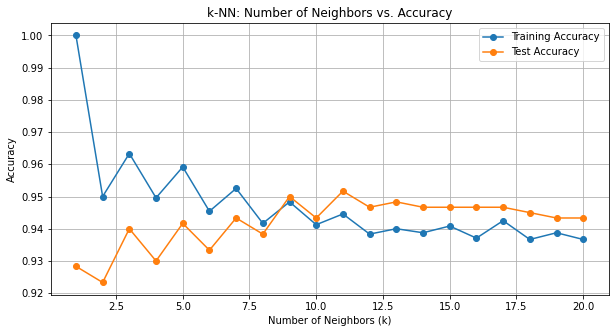

KNN with k=4 - Training Accuracy: 0.9496
KNN with k=4 - Test Accuracy: 0.9300
KNN Classification Report:
               precision    recall  f1-score   support

    Building       0.98      1.00      0.99       118
      Forest       0.72      0.99      0.83        99
     Glacier       1.00      1.00      1.00        96
   Mountains       1.00      0.99      1.00       101
         Sea       0.98      0.56      0.71        91
     Streets       1.00      1.00      1.00        95

    accuracy                           0.93       600
   macro avg       0.95      0.92      0.92       600
weighted avg       0.95      0.93      0.93       600

Feature Set 2:


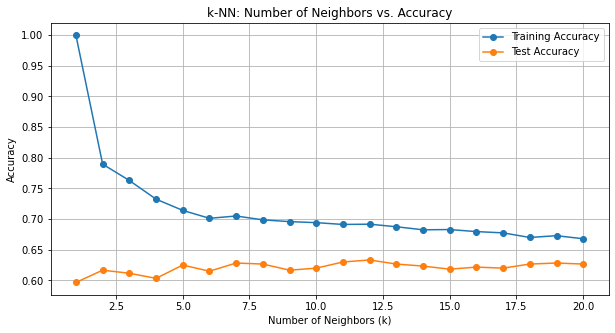

KNN with k=4 - Training Accuracy: 0.7325
KNN with k=4 - Test Accuracy: 0.6033
KNN Classification Report:
               precision    recall  f1-score   support

    Building       1.00      1.00      1.00       118
      Forest       0.55      0.77      0.64        99
     Glacier       0.32      0.34      0.33        96
   Mountains       0.27      0.20      0.23       101
         Sea       0.27      0.22      0.24        91
     Streets       1.00      1.00      1.00        95

    accuracy                           0.60       600
   macro avg       0.57      0.59      0.57       600
weighted avg       0.58      0.60      0.59       600

Feature Set 3:


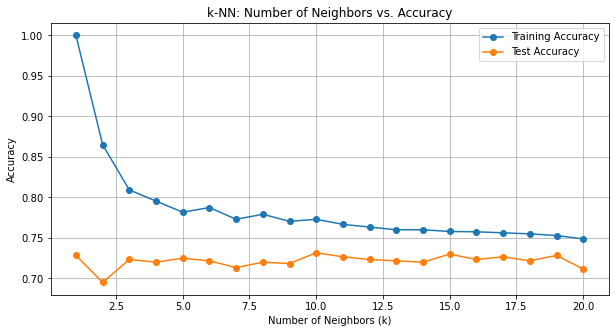

KNN with k=4 - Training Accuracy: 0.7954
KNN with k=4 - Test Accuracy: 0.7200
KNN Classification Report:
               precision    recall  f1-score   support

    Building       1.00      1.00      1.00       118
      Forest       0.74      0.98      0.84        99
     Glacier       0.97      0.65      0.78        96
   Mountains       0.59      0.35      0.44       101
         Sea       0.43      0.88      0.57        91
     Streets       1.00      0.42      0.59        95

    accuracy                           0.72       600
   macro avg       0.79      0.71      0.70       600
weighted avg       0.80      0.72      0.71       600



In [20]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

def train_and_evaluate(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Evaluate KNN for different values of k
    k_values = range(1, 21)  # Test k from 1 to 20
    train_accuracies = []
    test_accuracies = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Calculate training accuracy
        train_accuracy = accuracy_score(y_train, knn.predict(X_train))
        train_accuracies.append(train_accuracy)
        
        # Calculate test accuracy
        test_accuracy = accuracy_score(y_test, knn.predict(X_test))
        test_accuracies.append(test_accuracy)
    
    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='o')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.title('k-NN: Number of Neighbors vs. Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Final evaluation with k=5 (as in the original code)
    knn = KNeighborsClassifier(n_neighbors=4)
    knn.fit(X_train, y_train)
    
    # Calculate training and test accuracy
    train_accuracy = accuracy_score(y_train, knn.predict(X_train))
    test_accuracy = accuracy_score(y_test, knn.predict(X_test))
    
    print(f"KNN with k=4 - Training Accuracy: {train_accuracy:.4f}")
    print(f"KNN with k=4 - Test Accuracy: {test_accuracy:.4f}")
    print("KNN Classification Report:\n", classification_report(y_test, knn.predict(X_test)))

# Evaluate for each feature set
print("Feature Set 1:")
train_and_evaluate(features_set1, labels_set1)

print("Feature Set 2:")
train_and_evaluate(features_set2, labels_set2)

print("Feature Set 3:")
train_and_evaluate(features_set3, labels_set3)


Feature Set 1:


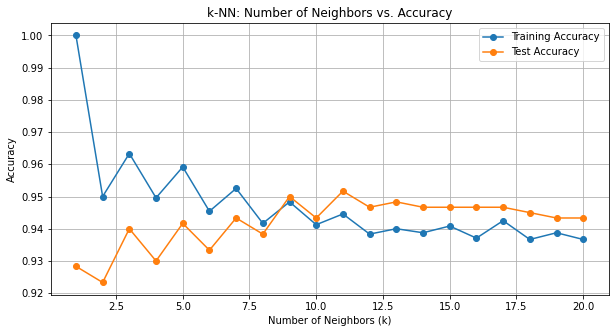

KNN with k=4 - Training Accuracy: 0.9496
KNN with k=4 - Test Accuracy: 0.9300
KNN Classification Report:
               precision    recall  f1-score   support

    Building       0.98      1.00      0.99       118
      Forest       0.72      0.99      0.83        99
     Glacier       1.00      1.00      1.00        96
   Mountains       1.00      0.99      1.00       101
         Sea       0.98      0.56      0.71        91
     Streets       1.00      1.00      1.00        95

    accuracy                           0.93       600
   macro avg       0.95      0.92      0.92       600
weighted avg       0.95      0.93      0.93       600

Unseen Image: unseen_data/buildings_2.jpg, Predicted Category: Building
Feature Set 3:


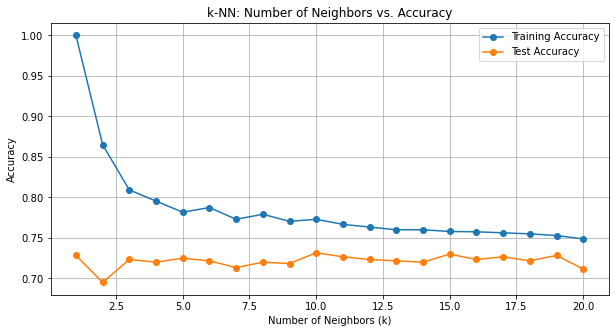

KNN with k=4 - Training Accuracy: 0.7954
KNN with k=4 - Test Accuracy: 0.7200
KNN Classification Report:
               precision    recall  f1-score   support

    Building       1.00      1.00      1.00       118
      Forest       0.74      0.98      0.84        99
     Glacier       0.97      0.65      0.78        96
   Mountains       0.59      0.35      0.44       101
         Sea       0.43      0.88      0.57        91
     Streets       1.00      0.42      0.59        95

    accuracy                           0.72       600
   macro avg       0.79      0.71      0.70       600
weighted avg       0.80      0.72      0.71       600

Unseen Image: unseen_data/buildings_2.jpg, Predicted Category: Building


In [22]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

def train_and_evaluate(features, labels, unseen_image_path):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Evaluate KNN for different values of k
    k_values = range(1, 21)  # Test k from 1 to 20
    train_accuracies = []
    test_accuracies = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Calculate training accuracy
        train_accuracy = accuracy_score(y_train, knn.predict(X_train))
        train_accuracies.append(train_accuracy)
        
        # Calculate test accuracy
        test_accuracy = accuracy_score(y_test, knn.predict(X_test))
        test_accuracies.append(test_accuracy)
    
    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='o')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.title('k-NN: Number of Neighbors vs. Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Final evaluation with k=4 (as in the original code)
    knn = KNeighborsClassifier(n_neighbors=4)
    knn.fit(X_train, y_train)
    
    # Calculate training and test accuracy
    train_accuracy = accuracy_score(y_train, knn.predict(X_train))
    test_accuracy = accuracy_score(y_test, knn.predict(X_test))
    
    print(f"KNN with k=4 - Training Accuracy: {train_accuracy:.4f}")
    print(f"KNN with k=4 - Test Accuracy: {test_accuracy:.4f}")
    print("KNN Classification Report:\n", classification_report(y_test, knn.predict(X_test)))

    # Predict on a single unseen image
    image = cv.imread(unseen_image_path)
    if image is not None:
        unseen_features = extract_features_set3(image, None)
        unseen_features = np.pad(unseen_features, (0, features.shape[1] - len(unseen_features)), mode='constant')
        unseen_features = unseen_features.reshape(1, -1)  # Reshape for a single prediction
        unseen_prediction = knn.predict(unseen_features)
        print(f"Unseen Image: {unseen_image_path}, Predicted Category: {unseen_prediction[0]}")

# Specify the path to the unseen image
unseen_image_path = 'unseen_data/buildings_2.jpg'

# Evaluate for each feature set
print("Feature Set 1:")
train_and_evaluate(features_set1, labels_set1, unseen_image_path)

# print("Feature Set 2:")
# train_and_evaluate(features_set2, labels_set2, unseen_image_path)

print("Feature Set 3:")
train_and_evaluate(features_set3, labels_set3, unseen_image_path)

In [16]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

def train_and_save_model(features, labels, model_path):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    # Evaluate KNN for different values of k
    k_values = range(1, 21)  # Test k from 1 to 20
    train_accuracies = []
    test_accuracies = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        # Calculate training accuracy
        train_accuracy = accuracy_score(y_train, knn.predict(X_train))
        train_accuracies.append(train_accuracy)
        # Calculate test accuracy
        test_accuracy = accuracy_score(y_test, knn.predict(X_test))
        test_accuracies.append(test_accuracy)
    
    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='o')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.title('k-NN: Number of Neighbors vs. Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Final evaluation with k=4 (as in the original code)
    knn = KNeighborsClassifier(n_neighbors=11)
    knn.fit(X_train, y_train)
    # Calculate training and test accuracy
    train_accuracy = accuracy_score(y_train, knn.predict(X_train))
    test_accuracy = accuracy_score(y_test, knn.predict(X_test))
    print(f"KNN with k=4 - Training Accuracy: {train_accuracy:.4f}")
    print(f"KNN with k=4 - Test Accuracy: {test_accuracy:.4f}")
    print("KNN Classification Report:\n", classification_report(y_test, knn.predict(X_test)))

    # Save the trained model
    joblib.dump(knn, model_path)
    print(f"Model saved to {model_path}")

Training and saving the model for Feature Set 3:


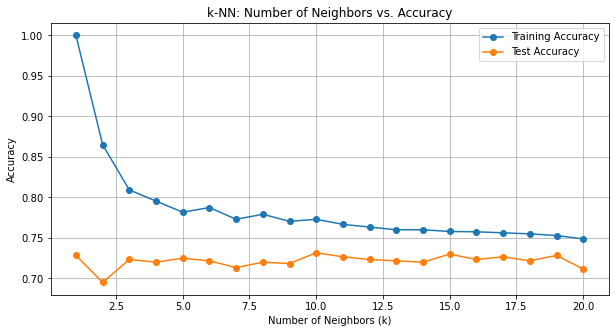

KNN with k=4 - Training Accuracy: 0.7667
KNN with k=4 - Test Accuracy: 0.7267
KNN Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       0.76      0.95      0.85        99
           2       0.93      0.70      0.80        96
           3       0.51      0.18      0.26       101
           4       0.44      0.97      0.60        91
           5       1.00      0.54      0.70        95

    accuracy                           0.73       600
   macro avg       0.77      0.72      0.70       600
weighted avg       0.78      0.73      0.71       600

Model saved to knn_model_set3b.pkl


In [17]:
# Train and save the model
model_path = 'knn_model_set3b.pkl'
print("Training and saving the model for Feature Set 3:")
train_and_save_model(features_set3, labels_set3, model_path)

In [20]:
def load_and_predict(model_path, unseen_image_path, feature_extractor, feature_shape):
    knn = joblib.load(model_path)
    image = cv.imread(unseen_image_path)
    if image is not None:
        unseen_features = feature_extractor(image, None)
        unseen_features = np.pad(unseen_features, (0, feature_shape - len(unseen_features)), mode='constant')
        unseen_features = unseen_features.reshape(1, -1)  # Reshape for a single prediction
        unseen_prediction = knn.predict(unseen_features)
        print(f"Unseen Image: {unseen_image_path}, Predicted Category: {unseen_prediction[0]}")

In [22]:
model_path = 'knn_model_set3.pkl'
# Predict on multiple unseen images
unseen_image_paths = ['unseen_data/forest2.jpg', 'unseen_data/forest3.jpg',
                      'unseen_data/forest4.jpg', 'unseen_data/mountains.jpg', 'unseen_data/mountains_2.jpg']

for unseen_image_path in unseen_image_paths:
    print(f"Predicting for unseen image: {unseen_image_path}")
    load_and_predict(model_path, unseen_image_path, extract_features_set3, features_set3.shape[1])

Predicting for unseen image: unseen_data/forest2.jpg


ValueError: X has 125022 features, but KNeighborsClassifier is expecting 22782 features as input.